In [22]:
import pickle
from pathlib import Path
import datetime
import codecs
import copy

from sklearn.metrics import confusion_matrix, roc_auc_score
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import IPython.display as ipd
from scipy.io import wavfile
from scipy import signal

import cv2

import tensorflow as tf


DATA_PATH = Path('data-kaggle')
DATA_TRAIN_PATH = DATA_PATH / 'train'
DATA_TEST_PATH = DATA_PATH / 'test'
BG_FILES = list(DATA_TRAIN_PATH.glob('audio/_background_noise_/*.wav'))

ALLOWED_LABELS = set(['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence'])

SAMPLE_RATE = 16000


def get_info_row(x):
    """Splits one row int path, label and user_id"""
    path = 'audio/' + x.split('\n')[0]
    label = transform_label(path.split('/')[-2])
    user_id = path.split('/')[2].split('_')[-3]
    return path, label, user_id

def transform_label(label):
    if label == "_background_noise_":
        label = 'silence'
    if label not in ALLOWED_LABELS:
        label = 'unknown'
    return label

def get_train_test_data_info_eval(data_path_train, data_path_test):
    """Returns list of tuples in format (path, label, user_id) with audio files from train (+val and test)
    and evaluation set"""
    train_info = []
    test_info = []
    
    for file_path in data_path_test.glob('*/*.wav'):
        path = str(file_path).split(str(data_path_test) + '/')[1]
        test_info.append((path,
                           None,
                           None))
    
      
    for file_path in data_path_train.glob('*/*/*.wav'):
        path = str(file_path).split(str(data_path_train) + '/')[1]
        train_info.append((path,
                           transform_label(path.split('/')[-2]),
                           path.split('/')[-1].split('_')[0]))

    return train_info, test_info

def load_test_data_info(data_path):
    """Returns list of tuples in format (path, label, user_id)"""
    with open(data_path / "validation_list.txt", "r") as f:
        validation_list = [x for x in f.readlines()]
    with open(data_path / "testing_list.txt", "r") as f:
        testing_list = [x for x in f.readlines()]

    test_info = validation_list + testing_list
    test_info = map(lambda x: get_info_row(x), test_info)
    return list(test_info)

def get_train_test_data_info(data_path):
    """Returns list of tuples in format (path, label, user_id). Merges validation_list.txt and train_list.txt"""
    test_info = load_test_data_info(data_path)
    
    train_info = []
    paths = set([x[0] for x in test_info])
    for file_path in data_path.glob('*/*/*.wav'):            
        path = str(file_path).split(str(data_path) + '/')[1]
        if path not in paths:
            train_info.append((path,
                               transform_label(path.split('/')[-2]),
                               path.split('/')[-1].split('_')[0]))

    return train_info, test_info


def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    """Computes log spectogram of a wav sample"""
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.astype(np.float32) + eps)
    
def pad_audio(samples, length=16000):
    """Pads samples that have less than 'length' samples with 0"""
    if len(samples) >= length:
        return samples
    else:
        return np.pad(samples, pad_width=(length - len(samples), 0), mode='constant', constant_values=(0, 0))

def chop_audio(samples, length=16000):
    """Chops audio to have 'length' samples"""
    return samples[:length]

def preprocess_data(file_path, test=False):
    """Applies transformations to the file (like computing spectrogram)"""
    sample_rate, samples = wavfile.read(file_path)
    samples = pad_audio(samples)
    samples = chop_audio(samples)
    
    #augument
    if not test:
        samples = random_speed(random_time_shift(samples))
    
    _, _, spectrogram = log_specgram(samples, sample_rate)
    return spectrogram.T

def get_plot_confusion_matrix(cmatrix):
    """Plots confusion matrix heatmap"""
    df_cm = pd.DataFrame(cmatrix, index = list(label_to_index.keys()),
                  columns = list(label_to_index.keys()))
    fig = plt.figure(figsize = (16, 9))
    sns.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")
    return fig

def get_summary(probs, true_labels):
    """Returns dict with accuracy, confusion matrix plot, binary probabilities per class and AUC per class"""
    pred_labels = np.argmax(probs, axis=1)
    accuracy = sum(pred_labels == true_labels) / len(test_labels)
    print(f"accuracy: {accuracy}")
    cmatrix = confusion_matrix(true_labels, pred_labels)
    plot = get_plot_confusion_matrix(cmatrix)
    index_to_label = {v: k for k, v in label_to_index.items()}
    
    aucs = []
    classes_probs = []
    classes_true_labels = []
    for class_label in label_to_index.values():
        class_label_verbose = index_to_label[class_label]
        
        class_true_labels = np.where(np.squeeze(true_labels) == class_label, 1, 0)
        class_probs = probs[:, class_label]
        classes_probs.append(class_probs.tolist())
        classes_true_labels.append(class_true_labels.tolist())
        
        auc = roc_auc_score(class_true_labels, class_probs)
        aucs.append(auc)
        print(f"class {class_label_verbose} AUC: {auc}")
        
    return {"accuracy": accuracy, "AUC_per_class": aucs, "plot": plot,
            "classes_probs": classes_probs, "classes_true_labels": classes_true_labels}
    

def save_results(model, hist, summary, description, results_dir="results"):
    """Saves model, summary and plot on a drive"""
    results_path = Path('results')
    date_str = datetime.datetime.now().strftime("%Y%m%dT%H%M")
    folder_name = f"results_{date_str}_{description}"
    results_folder_path = results_path / folder_name
    results_folder_path.mkdir()
    
    summary["plot"].savefig(results_folder_path / "cmatrix.png")
    
    summary_copy = summary.copy()
    summary_copy.pop("plot")
    
    model.save(results_folder_path / 'model.h5') 
    
    with open(results_folder_path / "evaluation.pkl", "wb") as f:
        pickle.dump(summary_copy, f)
        
    with open(results_folder_path / "history.pkl", "wb") as f:
        pickle.dump(hist.history, f)
    
    def model_summary_to_file(summary):
        with open(results_folder_path / "model_summary.txt", 'w') as f:
            print(summary, file=f)

    model.summary(print_fn=model_summary_to_file)
    print(f"Results saved in {results_folder_path}")
          

def random_speed(samples, prob=0.5):
    if np.random.uniform() > prob:
        return samples
    speed_rate = np.random.uniform(0.8, 1.1)
    wav_speed_tune = cv2.resize(samples, (1, int(len(samples) * speed_rate))).squeeze()
    if len(wav_speed_tune) < 16000:
        pad_len = 16000 - len(wav_speed_tune)
        wav_speed_tune = np.r_[np.random.uniform(-0.001,0.001,int(pad_len/2)),
                               wav_speed_tune,
                               np.random.uniform(-0.001,0.001,int(np.ceil(pad_len/2)))]
    else: 
        cut_len = len(wav_speed_tune) - 16000
        wav_speed_tune = wav_speed_tune[int(cut_len/2):int(cut_len/2)+16000]
    return wav_speed_tune


def random_noise(samples, prob=0.1):
    """With 'prob' probability adds random noise to the wav file"""
    if np.random.uniform() > prob:
        return samples
    chosen_bg_file = BG_FILES[np.random.randint(6)]
    bg_noise = wavfile.read(chosen_bg_file)[1]
    
    start_ = np.random.randint(bg_noise.shape[0] - 16000)
    bg_slice = bg_noise[start_ : start_ + 16000]
    ratio = np.random.uniform(0, 0.01)
    wav_with_bg = samples * (1 - ratio) + \
                  bg_slice * ratio
    return wav_with_bg

def random_time_shift(samples, intensity=0.8, prob=0.5):
    if np.random.uniform() > prob:
        return samples
    start_ = int(np.random.uniform(-4800 * intensity,4800 * intensity))
    if start_ >= 0:
        wav_time_shift = np.r_[samples[start_:], np.random.uniform(-0.001,0.001, start_)]
    else:
        wav_time_shift = np.r_[np.random.uniform(-0.001,0.001, -start_), samples[:start_]]
    return wav_time_shift

In [2]:
train_info, test_info = get_train_test_data_info(DATA_TRAIN_PATH)
np.random.shuffle(train_info)

In [3]:
train_paths = [str(DATA_TRAIN_PATH / x[0]) for x in train_info]
train_labels = [x[1] for x in train_info]

test_paths = [str(DATA_TRAIN_PATH / x[0]) for x in test_info]
test_labels = [x[1] for x in test_info]

label_to_index = dict((name, index) for index, name in enumerate(set(train_labels)))

train_labels = [np.array(label_to_index[x]) for x in train_labels]
test_labels = [np.array(label_to_index[x]) for x in test_labels]

In [4]:
def gen_X_train():
    """Returns generator of X_train values"""
    for path in train_paths:
        yield preprocess_data(path)
        
def gen_X_test():
    """Returns generator of X_test values"""
    for path in test_paths:
        yield preprocess_data(path, test=True)
        
def gen_y_train():
    """Returns generator of y train values"""
    for label in train_labels:
        yield label
        
def gen_y_test():
    """Returns generator of y test values"""
    for label in test_labels:
        yield label
        
def gen_X_train_without_augmentation():
    """Returns generator of X_train values"""
    for path in train_paths:
        yield preprocess_data(path, test=True)


### with augmentation

W0611 00:41:53.587363 140328219268928 deprecation.py:323] From /home/marcin/git/MGU-lstm/venv/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:410: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
W0611 00:41:53.685279 140328219268928 tf_logging.py:161

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 99, 16)            7744      
_________________________________________________________________
batch_normalization_v2 (Batc (None, 99, 16)            64        
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               41472     
_________________________________________________________________
dense (Dense)                (None, 12)                1548      
Total params: 50,828
Trainable params: 50,796
Non-trainable params: 32
_________________________________________________________________
Epoch 1/10
 293/1729 [====>.........................] - ETA: 2:08 - loss: 1.4623 - accuracy: 0.6320

/home/marcin/git/MGU-lstm/venv/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


1729/1729 [==============================] - 156s 90ms/step - loss: 1.1257 - accuracy: 0.6775 - val_loss: 0.7500 - val_accuracy: 0.7569
Epoch 2/10
1729/1729 [==============================] - 154s 89ms/step - loss: 0.6634 - accuracy: 0.7894 - val_loss: 0.4870 - val_accuracy: 0.8497
Epoch 3/10
1729/1729 [==============================] - 154s 89ms/step - loss: 0.4632 - accuracy: 0.8558 - val_loss: 0.4136 - val_accuracy: 0.8711
Epoch 4/10
1729/1729 [==============================] - 156s 90ms/step - loss: 0.3545 - accuracy: 0.8888 - val_loss: 0.3644 - val_accuracy: 0.8823
Epoch 5/10
1729/1729 [==============================] - 152s 88ms/step - loss: 0.2874 - accuracy: 0.9109 - val_loss: 0.2315 - val_accuracy: 0.9291
Epoch 6/10
1729/1729 [==============================] - 156s 90ms/step - loss: 0.2467 - accuracy: 0.9244 - val_loss: 0.2099 - val_accuracy: 0.9363
Epoch 7/10
1729/1729 [==============================] - 156s 90ms/step - loss: 0.2148 - accuracy: 0.9342 - val_loss: 0.1930 - val

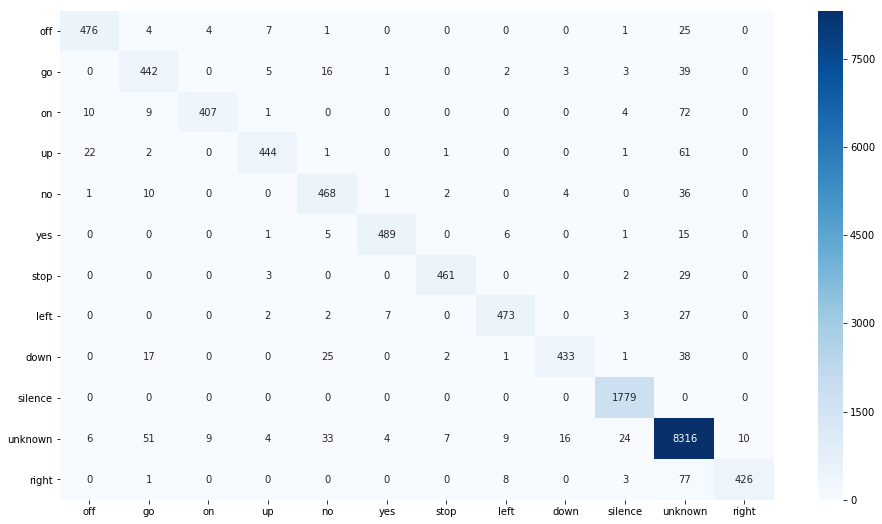

In [5]:
X_train = tf.data.Dataset.from_generator(gen_X_train, tf.float64)
y_train = tf.data.Dataset.from_generator(gen_y_train, tf.int32)
train_ds = tf.data.Dataset.zip((X_train, y_train))

X_test = tf.data.Dataset.from_generator(gen_X_test, tf.float64)
y_test = tf.data.Dataset.from_generator(gen_y_test, tf.int32)
test_ds = tf.data.Dataset.zip((X_test, y_test))

BATCH_SIZE = 32

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.shuffle(buffer_size=500).batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


def lr_schedule(epoch):
    if epoch > 15:
        return 0.00001
    elif epoch > 10:
        return 0.0001
    else:
        return 0.001
    
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              min_delta=0,
                                              patience=3,
                                              verbose=0, mode='auto')

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(input_shape=(99, 161), filters=16, kernel_size=3, activation='selu', padding='same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(len(ALLOWED_LABELS) + 1, activation=tf.keras.activations.softmax)
])
model.summary()

model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
steps_per_epoch = np.ceil(len(train_labels)/BATCH_SIZE)
scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
hist = model.fit(train_ds, epochs=10, steps_per_epoch=steps_per_epoch,
          validation_data=test_ds, callbacks=[scheduler, early_stopping])

preds = model.predict(test_ds)
summary = get_summary(preds, test_labels)
save_results(model, hist, summary, "small-bi-augment")

### without augmentation

W0610 23:35:09.280794 140481076959040 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fc3403a7e10>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0610 23:35:09.284867 140481076959040 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fc34033d828>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 99, 16)            7744      
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 99, 16)            64        
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               41472     
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1548      
Total params: 50,828
Trainable params: 50,796
Non-trainable params: 32
_________________________________________________________________
Epoch 1/10
 363/1729 [=====>........................] - ETA: 1:41 - loss: 1.3448 - accuracy: 0.6436

/home/marcin/git/MGU-lstm/venv/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


1729/1729 [==============================] - 143s 82ms/step - loss: 0.9656 - accuracy: 0.7108 - val_loss: 0.6609 - val_accuracy: 0.7946
Epoch 2/10
1729/1729 [==============================] - 136s 79ms/step - loss: 0.4970 - accuracy: 0.8442 - val_loss: 0.4480 - val_accuracy: 0.8661
Epoch 3/10
1729/1729 [==============================] - 144s 83ms/step - loss: 0.3290 - accuracy: 0.8978 - val_loss: 0.3239 - val_accuracy: 0.9005
Epoch 4/10
1729/1729 [==============================] - 145s 84ms/step - loss: 0.2443 - accuracy: 0.9248 - val_loss: 0.2445 - val_accuracy: 0.9262
Epoch 5/10
1729/1729 [==============================] - 136s 79ms/step - loss: 0.1996 - accuracy: 0.9384 - val_loss: 0.2709 - val_accuracy: 0.9152
Epoch 6/10
1729/1729 [==============================] - 147s 85ms/step - loss: 0.1715 - accuracy: 0.9472 - val_loss: 0.2018 - val_accuracy: 0.9402
Epoch 7/10
1729/1729 [==============================] - 156s 90ms/step - loss: 0.1492 - accuracy: 0.9541 - val_loss: 0.1950 - val

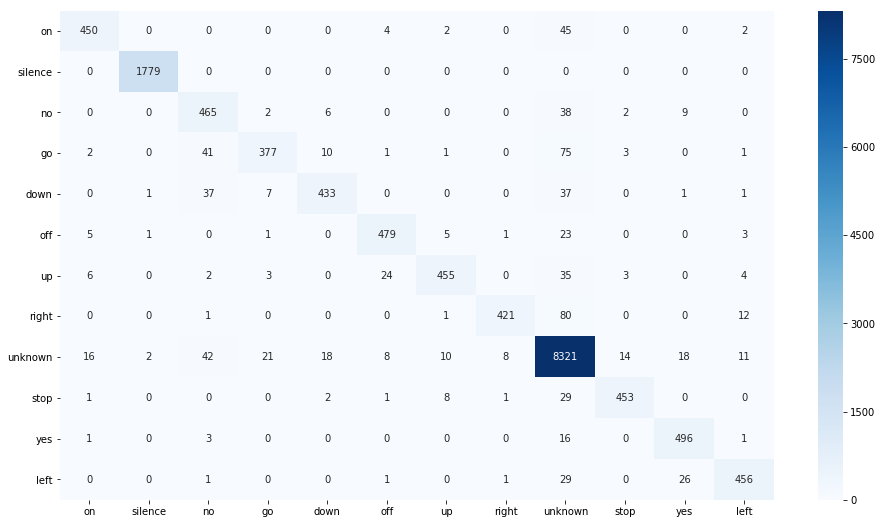

In [7]:
X_train = tf.data.Dataset.from_generator(gen_X_train_without_augmentation, tf.float64)
y_train = tf.data.Dataset.from_generator(gen_y_train, tf.int32)
train_ds = tf.data.Dataset.zip((X_train, y_train))

X_test = tf.data.Dataset.from_generator(gen_X_test, tf.float64)
y_test = tf.data.Dataset.from_generator(gen_y_test, tf.int32)
test_ds = tf.data.Dataset.zip((X_test, y_test))

train_ds = train_ds.shuffle(buffer_size=500).batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

steps_per_epoch = np.ceil(len(train_labels)/BATCH_SIZE)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(input_shape=(99, 161), filters=16, kernel_size=3, activation='selu', padding='same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(len(ALLOWED_LABELS) + 1, activation=tf.keras.activations.softmax)
])
model.summary()

model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
hist = model.fit(train_ds, epochs=10, steps_per_epoch=steps_per_epoch,
          validation_data=test_ds, callbacks=[scheduler, early_stopping])

preds = model.predict(test_ds)
summary = get_summary(preds, test_labels)
save_results(model, hist, summary, "small-bi")

### only lstm with augmentation

W0611 01:08:36.636513 140328219268928 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fa0180fd2b0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0611 01:08:36.639214 140328219268928 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f9fa84db8d0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


Epoch 1/10
 293/1729 [====>.........................] - ETA: 2:00 - loss: 1.4738 - accuracy: 0.6021

/home/marcin/git/MGU-lstm/venv/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


1729/1729 [==============================] - 167s 96ms/step - loss: 1.1732 - accuracy: 0.6401 - val_loss: 0.9097 - val_accuracy: 0.7098
Epoch 2/10
1729/1729 [==============================] - 169s 98ms/step - loss: 0.8780 - accuracy: 0.7153 - val_loss: 0.6987 - val_accuracy: 0.7839
Epoch 3/10
1729/1729 [==============================] - 166s 96ms/step - loss: 0.7780 - accuracy: 0.7544 - val_loss: 0.6578 - val_accuracy: 0.7956
Epoch 4/10
1729/1729 [==============================] - 170s 98ms/step - loss: 0.6994 - accuracy: 0.7774 - val_loss: 0.6034 - val_accuracy: 0.8105
Epoch 5/10
1729/1729 [==============================] - 179s 103ms/step - loss: 0.6623 - accuracy: 0.7939 - val_loss: 0.6188 - val_accuracy: 0.7996
Epoch 6/10
1729/1729 [==============================] - 174s 100ms/step - loss: 0.6254 - accuracy: 0.8068 - val_loss: 0.5769 - val_accuracy: 0.8128
Epoch 7/10
1729/1729 [==============================] - 178s 103ms/step - loss: 0.6006 - accuracy: 0.8075 - val_loss: 0.5212 - 

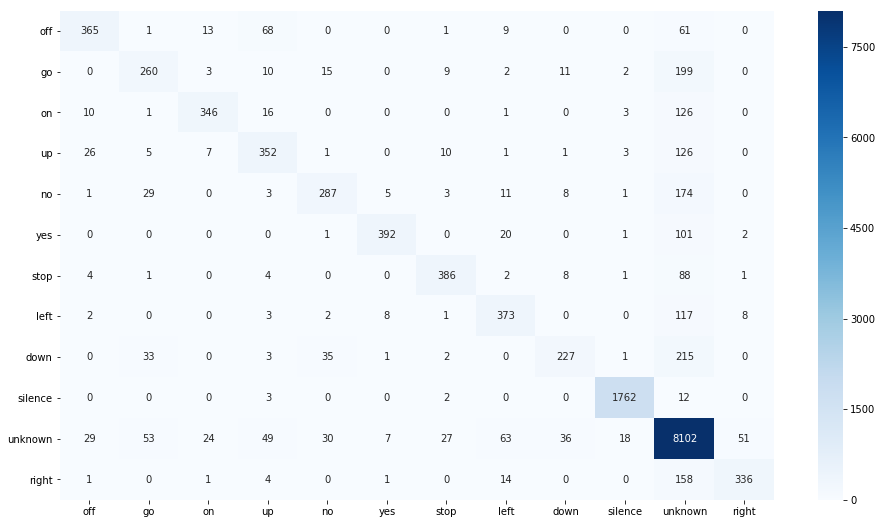

In [6]:
X_train = tf.data.Dataset.from_generator(gen_X_train, tf.float64)
y_train = tf.data.Dataset.from_generator(gen_y_train, tf.int32)
train_ds = tf.data.Dataset.zip((X_train, y_train))

X_test = tf.data.Dataset.from_generator(gen_X_test, tf.float64)
y_test = tf.data.Dataset.from_generator(gen_y_test, tf.int32)
test_ds = tf.data.Dataset.zip((X_test, y_test))

train_ds = train_ds.shuffle(buffer_size=500).batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

steps_per_epoch = np.ceil(len(train_labels)/BATCH_SIZE)


model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(len(ALLOWED_LABELS) + 1, activation=tf.keras.activations.softmax)
])


model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
steps_per_epoch = np.ceil(len(train_labels)/BATCH_SIZE)
scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
hist = model.fit(train_ds, epochs=10, steps_per_epoch=steps_per_epoch,
          validation_data=test_ds, callbacks=[scheduler, early_stopping])

preds = model.predict(test_ds)
summary = get_summary(preds, test_labels)
save_results(model, hist, summary, "only-lstm-augment")

### 2x lstm

W0611 06:41:57.215477 140328219268928 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f9e41570c18>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0611 06:41:57.218873 140328219268928 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f9e415743c8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0611 06:41:57.222886 140328219268928 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f9e41574a90>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0611 06:41:57.225883 140328219268928 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f9e415730f0>: Note that this layer is not optimized for performance. Please use tf.keras.laye

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 99, 16)            7744      
_________________________________________________________________
batch_normalization_v2_17 (B (None, 99, 16)            64        
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 99, 32)            1568      
_________________________________________________________________
batch_normalization_v2_18 (B (None, 99, 32)            128       
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 99, 128)           49664     
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_7 (Dense)              (None, 12)               

/home/marcin/git/MGU-lstm/venv/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


1729/1729 [==============================] - 205s 119ms/step - loss: 0.9302 - accuracy: 0.7279 - val_loss: 0.5258 - val_accuracy: 0.8389
Epoch 2/10
1729/1729 [==============================] - 205s 118ms/step - loss: 0.4620 - accuracy: 0.8563 - val_loss: 0.3971 - val_accuracy: 0.8794
Epoch 3/10
1729/1729 [==============================] - 191s 111ms/step - loss: 0.3216 - accuracy: 0.9011 - val_loss: 0.2789 - val_accuracy: 0.9132
Epoch 4/10
1729/1729 [==============================] - 189s 109ms/step - loss: 0.2504 - accuracy: 0.9216 - val_loss: 0.2122 - val_accuracy: 0.9347
Epoch 5/10
1729/1729 [==============================] - 186s 108ms/step - loss: 0.2099 - accuracy: 0.9355 - val_loss: 0.1852 - val_accuracy: 0.9442
Epoch 6/10
1729/1729 [==============================] - 190s 110ms/step - loss: 0.1824 - accuracy: 0.9432 - val_loss: 0.1685 - val_accuracy: 0.9503
Epoch 7/10
1729/1729 [==============================] - 197s 114ms/step - loss: 0.1644 - accuracy: 0.9505 - val_loss: 0.163

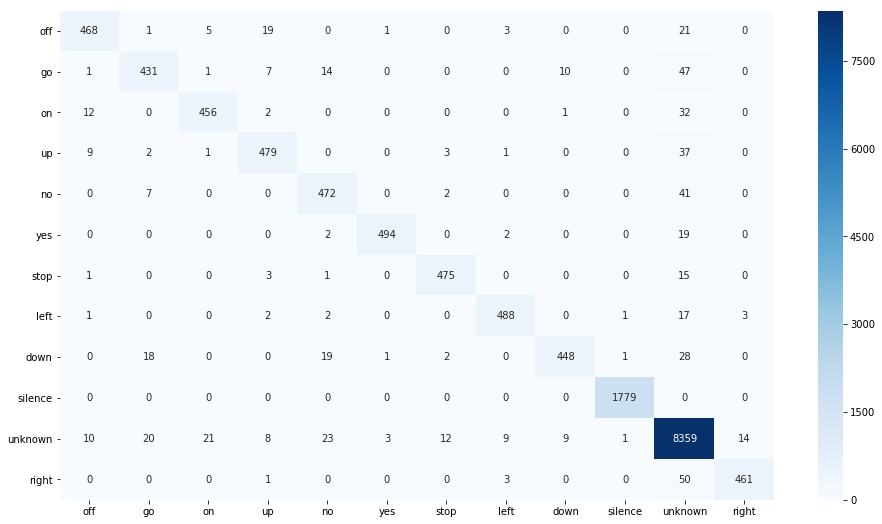

In [29]:
X_train = tf.data.Dataset.from_generator(gen_X_train, tf.float64)
y_train = tf.data.Dataset.from_generator(gen_y_train, tf.int32)
train_ds = tf.data.Dataset.zip((X_train, y_train))

X_test = tf.data.Dataset.from_generator(gen_X_test, tf.float64)
y_test = tf.data.Dataset.from_generator(gen_y_test, tf.int32)
test_ds = tf.data.Dataset.zip((X_test, y_test))

BATCH_SIZE = 32

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.shuffle(buffer_size=500).batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


def lr_schedule(epoch):
    if epoch > 15:
        return 0.00001
    elif epoch > 10:
        return 0.0001
    else:
        return 0.001
    
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              min_delta=0,
                                              patience=3,
                                              verbose=0, mode='auto')

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(input_shape=(99, 161), filters=16, kernel_size=3, activation='selu', padding='same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='selu', padding='same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(len(ALLOWED_LABELS) + 1, activation=tf.keras.activations.softmax)
])
model.summary()

model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
steps_per_epoch = np.ceil(len(train_labels)/BATCH_SIZE)

scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
hist = model.fit(train_ds, epochs=10, steps_per_epoch=steps_per_epoch,
          validation_data=test_ds, callbacks=[scheduler, early_stopping])

preds = model.predict(test_ds)
summary = get_summary(preds, test_labels)
save_results(model, hist, summary, "small-bi-augment-2x-attention")

## Evaluation

In [17]:
eval_train_info, eval_test_info = get_train_test_data_info_eval(DATA_TRAIN_PATH, DATA_TEST_PATH)
np.random.shuffle(eval_train_info)

In [ ]:
eval_test_paths = [str(DATA_TEST_PATH / x[0]) for x in eval_test_info]
eval_train_paths = [str(DATA_TRAIN_PATH / x[0]) for x in eval_train_info]

eval_train_labels = [x[1] for x in eval_train_info]

eval_label_to_index = dict((name, index) for index, name in enumerate(set(eval_train_labels)))

eval_train_labels = [eval_label_to_index[x] for x in eval_train_labels]
        
def gen_X_test_eval():
    """Returns generator of X_test values"""
    for path in eval_test_paths:
        yield preprocess_data(path, test=True)
        
        
def gen_X_train_eval():
    """Returns generator of X_train values"""
    for path in eval_train_paths:
        yield preprocess_data(path)
                
def gen_y_train_eval():
    """Returns generator of y train values"""
    for label in eval_train_labels:
        yield label
        
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
        
X_train_eval = tf.data.Dataset.from_generator(gen_X_train_eval, tf.float64)
y_train_eval = tf.data.Dataset.from_generator(gen_y_train_eval, tf.int32)
train_eval_ds = tf.data.Dataset.zip((X_train_eval, y_train_eval))
train_eval_ds = train_eval_ds.shuffle(buffer_size=10000).batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)

        
eval_test_ds = tf.data.Dataset.from_generator(gen_X_test_eval, tf.float64).batch(BATCH_SIZE).prefetch(AUTOTUNE)

steps_per_epoch = np.ceil(len(eval_train_labels)/BATCH_SIZE)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(input_shape=(99, 161), filters=16, kernel_size=3, activation='selu', padding='same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='selu', padding='same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(len(ALLOWED_LABELS) + 1, activation=tf.keras.activations.softmax)
])
model.summary()

model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)

model.fit(train_eval_ds, epochs=20, steps_per_epoch=steps_per_epoch,
          callbacks=[scheduler])

preds_eval = model.predict(eval_test_ds)

In [21]:
labels_eval = np.argmax(preds_eval, axis=1)
index_to_label = {v: k for k, v in label_to_index.items()}
labels_eval = [index_to_label[x] for x in labels_eval]
paths = [x[0].split('/')[1] for x in eval_test_info]

data_submit = pd.DataFrame(zip(paths, labels_eval), columns=('fname', 'label'))
data_submit.to_csv("submission2.csv", sep=",", index=False)